# Tabular RL

### SARSA

In [24]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym.wrappers import StepAPICompatibility
from itertools import chain


In [25]:
def softmax(x, temp):
  # P(a|s) = exp(Q(s,a) / T ) / sum_a(exp(Q(s,a) / T))
  exp_x = np.exp(np.array(x) / temp)
  return exp_x / np.sum(exp_x)


In [26]:
class Sarsa:
  def __init__(self, env, alpha, gamma, temp):
    # write your solution here
    
    self.env = env # environment
    self.alpha = alpha # learning rate
    self.gamma = gamma # discount factor
    self.temp = temp # temperature
    
    # Q table: S x A -> R, where:
    # S is the number of states  
    # A is the number of actions
    # R is the reward
    # Q[s, a] stores expected reward for taking action a in state s
    self.Q = np.zeros((env.observation_space.n, env.action_space.n)) 

  def select_action(self, s, greedy=False):
    # write your solution here
    if greedy:
      # if finished training, then choose the optimal policy
     
      # return the action with the highest Q value
      return np.argmax(self.Q[s])
  
    else:
 
      softmax_prob = softmax(self.Q[s], self.temp) # P(a|s) = exp(Q(s,a) / T ) / sum_a(exp(Q(s,a) / T))
      
      return np.random.choice(len(self.Q[s]), p=softmax_prob)

  def update(self, s, a, r, s_prime, a_prime, done):
    
    if done: # case for gamma = 0
      # Q(s,a) = Q(s,a) + alpha * (r - Q(s,a))
      self.Q[s, a] = self.Q[s, a] + self.alpha * (r - self.Q[s, a])
    else:
      # Q(s,a) = Q(s,a) + alpha * (r + gamma * Q(s',a') - Q(s,a))
      self.Q[s, a] = self.Q[s, a] + self.alpha * (r + self.gamma * self.Q[s_prime, a_prime] - self.Q[s, a])


class ExpectedSarsa:
  def __init__(self, env, alpha, gamma, temp):
    # write your solution here
    self.env = env # environment
    self.alpha = alpha # learning rate
    self.gamma = gamma # discount factor
    self.temp = temp # temperature
    
    # Q table: S x A -> R, where:
    # S is the number of states  
    # A is the number of actions
    # R is the reward
    # Q[s, a] stores expected reward for taking action a in state s
    self.Q = np.zeros((env.observation_space.n, env.action_space.n)) 


  def select_action(self, s, greedy=False):
    if greedy:
      # if finished training, then choose the optimal policy
      # return the action with the highest Q value
      return np.argmax(self.Q[s])
  
    else:
     
      softmax_prob = softmax(self.Q[s], self.temp) # P(a|s) = exp(Q(s,a) / T ) / sum_a(exp(Q(s,a) / T))
      return np.random.choice(len(softmax_prob), p=softmax_prob)
  

  def update(self, s, a, r, s_prime, a_prime, done): 
    if done:
      self.Q[s,a] = self.Q[s,a] + self.alpha * ( r - self.Q[s,a] )
    else: 
      # E[Q(s,a)] = sum_a'(P(a'|s') * Q(s',a')) = sum_a'(softmax(Q(s',a'), temp) * Q(s',a')) 
      expected_value = np.sum(softmax(self.Q[s_prime], self.temp) * self.Q[s_prime])
      # Q(s,a) = Q(s,a) + alpha * (r + gamma * E[Q(s',a')] - Q(s,a))
      self.Q[s,a] = self.Q[s,a] + self.alpha * ( r + self.gamma * expected_value - self.Q[s,a] )
    # write your solution here

  
# bonus question, optional
class Hybrid_Sarsa_Q:
  def __init__(self, env, alpha, gamma, temp):
    # write your solution here
    self.env = None
    self.alpha = None
    self.gamma = None
    self.temp = None
    self.Q = None
    return

  def select_action(self, s, greedy=False):
    # write your solution here
    if greedy:
      # if finished training, then choose the optimal policy
      return
    else:
      return

  def update(self, s, a, r, s_prime, a_prime, done):
    # write your solution here
    return


In [27]:
env_name = 'FrozenLake-v1'
env = gym.make(env_name)
env = StepAPICompatibility(env)
print("Action space:", env.action_space)
print("State space:", env.observation_space)

Action space: Discrete(4)
State space: Discrete(16)


In [28]:
def run_episode(agent, env, max_steps, greedy=False):
  s, _ = env.reset()  # reset the environment
  state_index = s  # Extract the state index from the tuple
  total_reward = 0  # initialize the total reward
  
  for _ in range(max_steps):
    a = agent.select_action(state_index, greedy)  # Use the state index for action selection
  
    s_prime, r, terminated, truncated, info = env.step(a)
    done = terminated or truncated
    state_prime_index = s_prime  # Extract the state index from s_prime tuple
    a_prime = agent.select_action(state_prime_index, greedy)
    agent.update(state_index, a, r, state_prime_index, a_prime, done)  # Use the state indices
    
    state_index = state_prime_index  # Update state index to the new state
    total_reward += r
    if done:
      break
  return total_reward

def run_experiment(agent_class, env, gamma, temp, alpha, num_trials=10, num_segments=500, episodes_per_segment=10, max_steps=1000):
    rewards = np.zeros((num_trials, num_segments))
    testing_rewards = np.zeros((num_trials, num_segments))
    
    for trial in range(num_trials):
        agent = agent_class(env, alpha, gamma, temp)
        for segment in range(num_segments):
            segment_reward = 0
            for _ in range(episodes_per_segment):
                segment_reward += run_episode(agent, env, max_steps)
            rewards[trial, segment] = segment_reward / episodes_per_segment  # Averaged over 10 episodes
            
            # Testing phase (greedy policy)
            testing_rewards[trial, segment] = run_episode(agent, env, max_steps, greedy=True)
    
    return rewards, testing_rewards

def run_experiments(agent_class, env, gammas, temps, alphas, num_trials=10, num_segments=500, episodes_per_segment=10, max_steps=1000):
    results = {}
    results_test = {}

    for gamma in gammas:
        results[gamma] = {}
        results_test[gamma] = {}
        for temp in temps:
            results[gamma][temp] = {}
            results_test[gamma][temp] = {}
            for alpha in alphas:
                rewards, testing_rewards = run_experiment(agent_class, env, gamma, temp, alpha, num_trials, num_segments, episodes_per_segment, max_steps)
                results[gamma][temp][alpha] = rewards
                results_test[gamma][temp][alpha] = testing_rewards

    return results, results_test

## Graphs Code

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


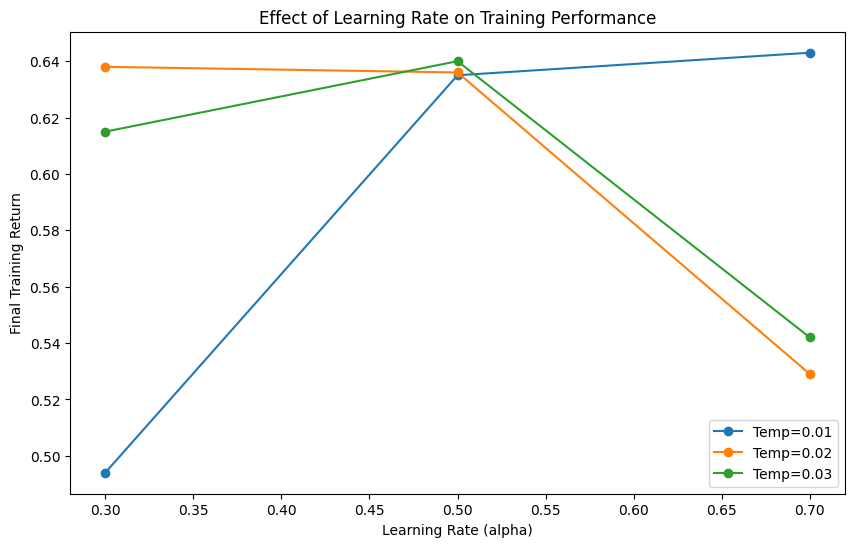

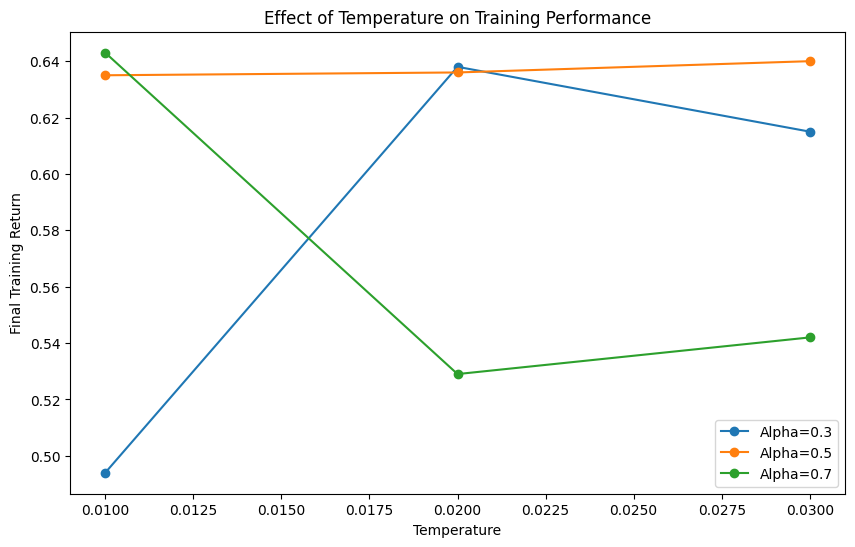

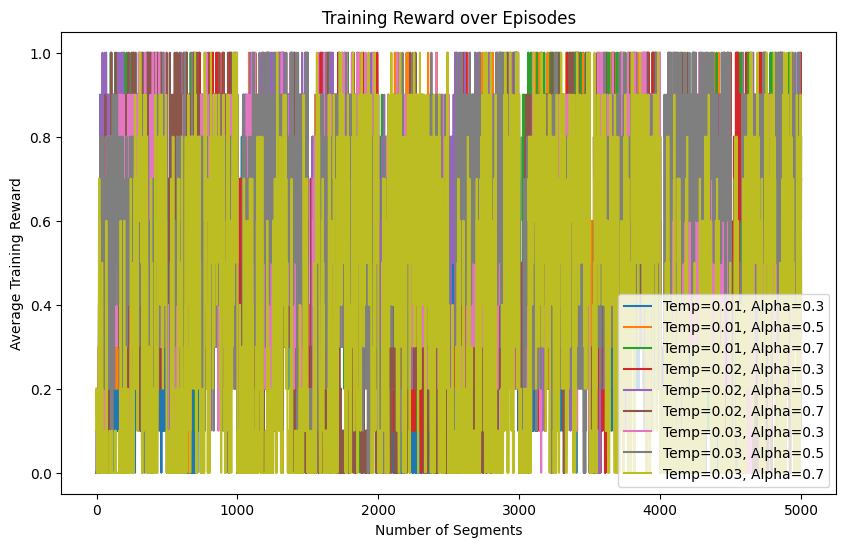

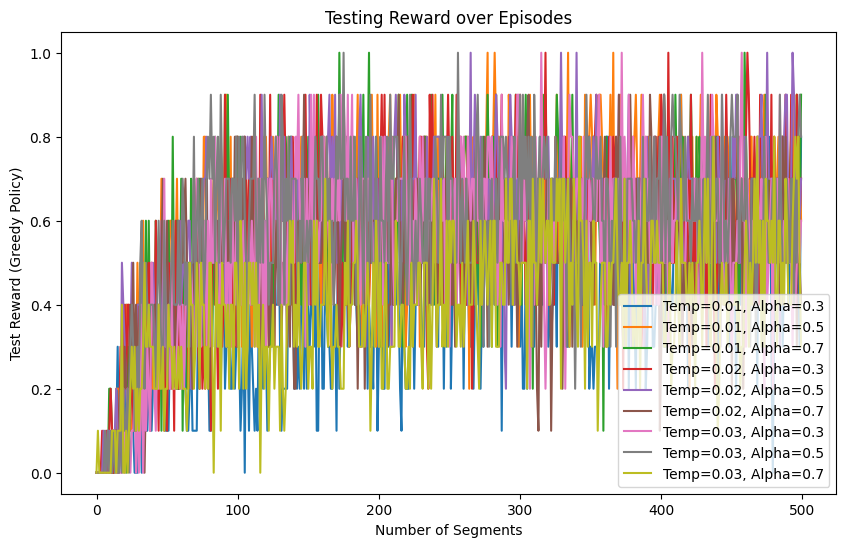

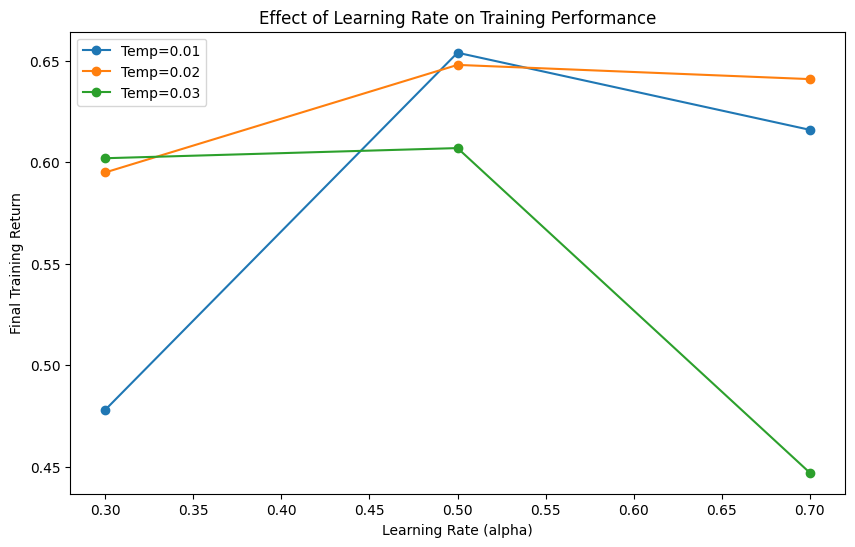

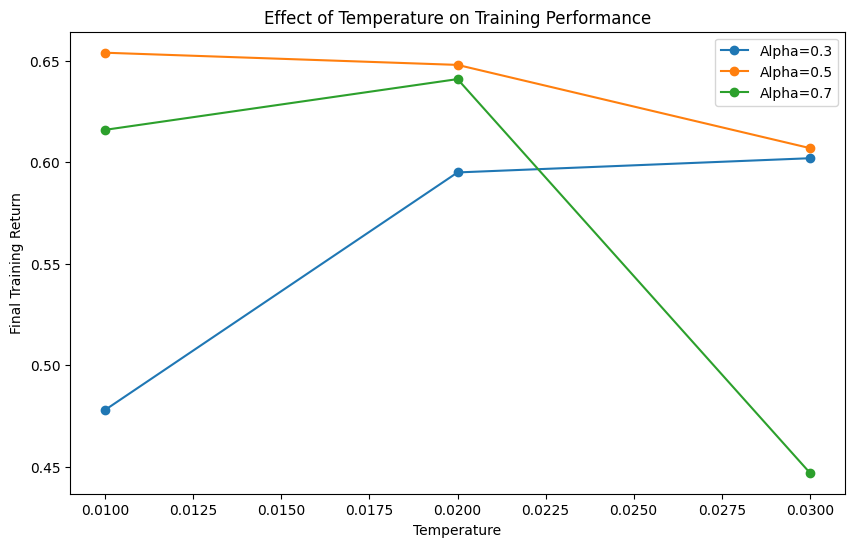

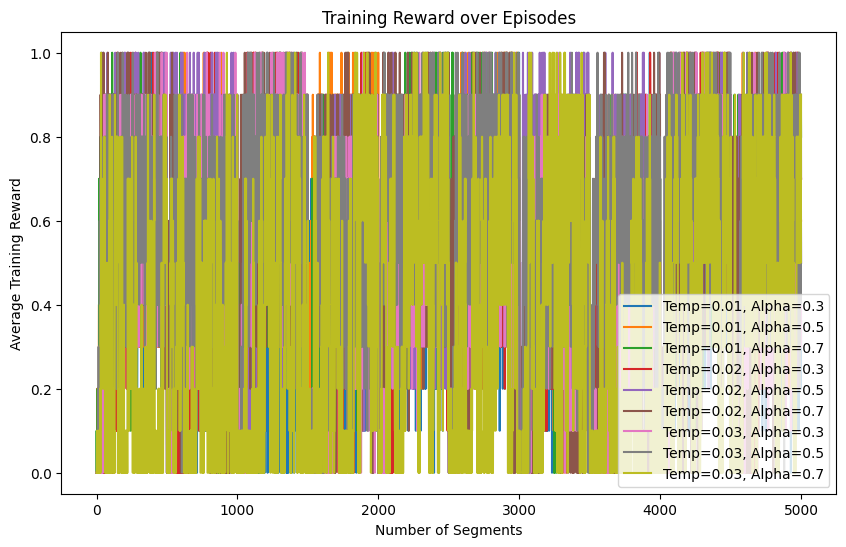

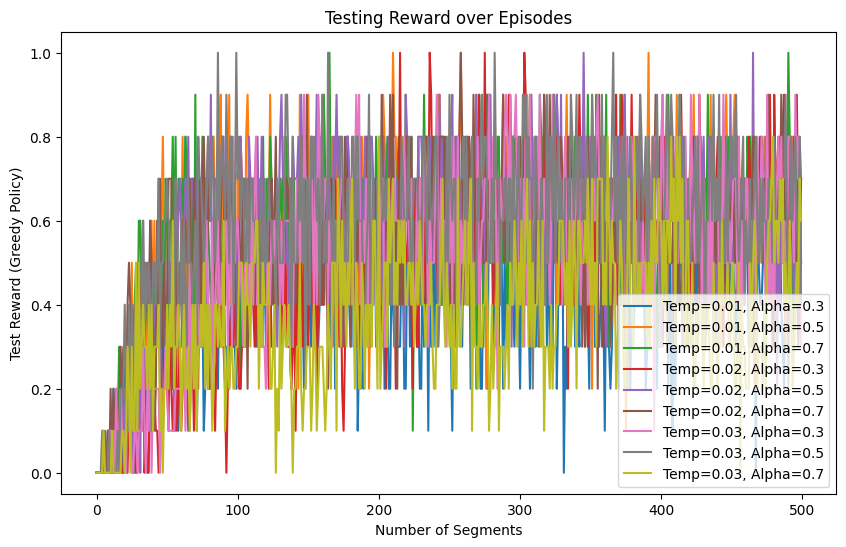

In [29]:
def plot_training_rewards(results, alphas, temps, gammas):
    plt.figure(figsize=(12, 6))
    for gamma in gammas:
        for temp in temps:
            for alpha in alphas:
                plt.plot(results[gamma][temp][alpha], label=f"Gamma={gamma}, Temp={temp}, Alpha={alpha}")
    
    plt.xlabel("Episode")
    plt.ylabel("Return (per episode)")
    plt.title("Training Performance")
    plt.legend()
    plt.grid()
    plt.show()

def plot_testing_rewards(test_results, alphas, temps, gammas):
    plt.figure(figsize=(12, 6))
    for gamma in gammas:
        for temp in temps:
            for alpha in alphas:
                plt.plot(test_results[gamma][temp][alpha], label=f"Gamma={gamma}, Temp={temp}, Alpha={alpha}")
    
    plt.xlabel("Episode")
    plt.ylabel("Return (greedy policy per episode)")
    plt.title("Testing Performance")
    plt.legend()
    plt.grid()
    plt.show()

def plot_results(results, results_test, alphas, temps, num_segments):
    # Compute averages over the last 10 training episodes
    avg_training_rewards = {temp: {alpha: np.mean(results[1.0][temp][alpha][:, -10:], axis=1) for alpha in alphas} for temp in temps}
    avg_testing_rewards = {temp: {alpha: np.mean(results_test[1.0][temp][alpha][:, -10:], axis=1) for alpha in alphas} for temp in temps}
    
    # Plot training performance (alpha vs return)
    plt.figure(figsize=(10, 6))
    for temp in temps:
        means = [np.mean(avg_training_rewards[temp][alpha]) for alpha in alphas]
        plt.plot(alphas, means, marker='o', label=f'Temp={temp}')
    plt.xlabel('Learning Rate (alpha)')
    plt.ylabel('Final Training Return')
    plt.legend()
    plt.title('Effect of Learning Rate on Training Performance')
    plt.show()
    
    # Plot training performance (temp vs return)
    plt.figure(figsize=(10, 6))
    for alpha in alphas:
        means = [np.mean(avg_training_rewards[temp][alpha]) for temp in temps]
        plt.plot(temps, means, marker='o', label=f'Alpha={alpha}')
    plt.xlabel('Temperature')
    plt.ylabel('Final Training Return')
    plt.legend()
    plt.title('Effect of Temperature on Training Performance')
    plt.show()
    
    # Plot training reward over episodes
    plt.figure(figsize=(10, 6))
    for temp in temps:
        for alpha in alphas:
            rewards = results[1.0][temp][alpha]
            concatenated_rewards = np.hstack(rewards)
            plt.plot(range(num_segments * 10), concatenated_rewards, label=f'Temp={temp}, Alpha={alpha}')
    plt.xlabel('Number of Segments')
    plt.ylabel('Average Training Reward')
    plt.legend()
    plt.title('Training Reward over Episodes')
    plt.show()
    
    # Plot testing performance (test reward over episodes)
    plt.figure(figsize=(10, 6))
    for temp in temps:
        for alpha in alphas:
            avg_test_rewards = np.mean(results_test[1.0][temp][alpha], axis=0)
            plt.plot(range(num_segments), avg_test_rewards, label=f'Temp={temp}, Alpha={alpha}')
    plt.xlabel('Number of Segments')
    plt.ylabel('Test Reward (Greedy Policy)')
    plt.legend()
    plt.title('Testing Reward over Episodes')
    plt.show()

# Define the hyperparameters
gammas = [1]
temps = [0.01, 0.02, 0.03]
alphas = [0.3, 0.5, 0.7]

results, testing_result = run_experiments(Sarsa, env, gammas, temps, alphas)
plot_results(results, testing_result, alphas, temps, num_segments=500)


results, testing_result = run_experiments(ExpectedSarsa, env, gammas, temps, alphas)
plot_results(results, testing_result, alphas, temps, num_segments=500)


## MDP